# CPDonkey December Notebook
Notebook detailing the formation of a donkeycar pilot using a Deep CNN and a single input image

In [1]:
##Data Profile

#Image Data Example

#Labels

In [3]:
#IMPORTS
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\l

The data that is fed into the donkeycar's pilot is a single input image. The donkeycar must be able to determine from this image whether to turn left or right. 

This image is a photo taken by the Donkeycar's front-facing camera with a resolution of 120x160. Each image, when taken, is labeled with a user angle (between -1 and 1) and a user throttle (between -1 and 1) - these labels are generated by the donkey program.

Below is an example of a photo taken by the donkey camera. This image has a corresponding json record file listing the angle, throttle, and the milliseconds elapsed since the data recording has started.

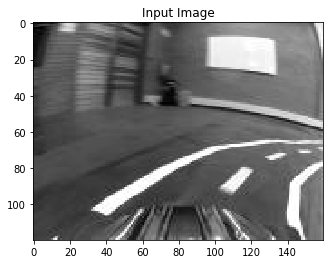

In [3]:
#Data Example
inImg = cv2.imread("101_cam-image_array_.jpg",0)
plt.title('Input Image')
plt.imshow(inImg, cmap = 'gray')

In [1]:
##What must be determined to achieve 'portability'?

#Lane Detection

#Background/Foreground Separation

The above image is fed into the neural network as-is. There is no help provided to the network in finding features such as lane lines etc. This means that the model is very constrained to the environment that it was trained in.

This problem can be solved by training it using many pictures from many different records collected over time and from other donkeycars - but this is time consuming and does not guarantee portability. A better method of making this model more 'portable' would be to incorporate a form of lane detection.

Lane detection can be accomplished by:
*Edge Detection
*Thresholding Images
*U-Net for Image Masking

Text(0.5, 0.98, 'Image Comparison: Canny Edge Detection')

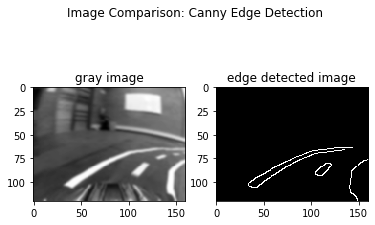

In [7]:
##Edge Detection

#Let's begin with edge detection. This is already built into some of the available parts for the donkey and makes use of 
#canny edge detection. We will show an example using the built-in opencv tools

imageIn = cv2.imread("101_cam-image_array_.jpg",0)
imageIn = cv2.GaussianBlur(imageIn, (5,5), 0)  #Gaussian Blur with a 5x5 kernel
edges = cv2.Canny(imageIn, 500, 200)    #Canny edge detection algorithm with threshold1 set that the strongest edges are found first

plt.subplot(121)
plt.title('gray image')
plt.imshow(imageIn, cmap = 'gray')
plt.subplot(122)
plt.title('edge detected image')
plt.imshow(edges, cmap = 'gray')
plt.suptitle('Image Comparison: Canny Edge Detection')

now: 1579197529022
Post Imread: 1579197529040
Post Numpy Threshold:1579197529044
Post CV Threshold:1579197529050


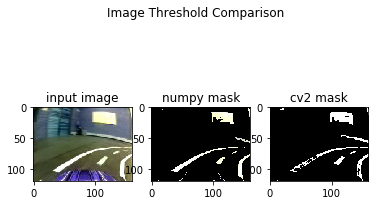

In [5]:
import time

## Thresholding

#Another method of lane detection/isolation could be image thresholding based on colour. A mask is applied to the image based
#on the colour that is to be detected - for example all colours within a certain family of white would most likely count as a
#lane line.

print('now: %d' % int(round(time.time() * 1000)))

imageIn = cv2.imread("101_cam-image_array_.jpg")

print('Post Imread: %d' % int(round(time.time() * 1000)))
#Threshold using numpy:
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold_white = [red_threshold, green_threshold, blue_threshold]

colorMaskWhite = (imageIn[:,:,0] < rgb_threshold_white[0]) | \
                    (imageIn[:,:,1] < rgb_threshold_white[1]) | \
                    (imageIn[:,:,2] < rgb_threshold_white[2])

localImage = np.copy(imageIn)
localImage[colorMaskWhite ] = [0,0,0] 

print('Post Numpy Threshold:%d' % int(round(time.time() * 1000)))
#Threshold using OpenCV:
roiHSV = cv2.cvtColor(imageIn, cv2.COLOR_BGR2HSV) #Convert image from bgr to hsv - using hue and saturation to apply mask

#Threshold for white side lane lines
lowerLIMIT = np.array([20,0,200],np.uint8)
upperLIMIT = np.array([100,60,255],np.uint8)

colLow = lowerLIMIT
colHigh = upperLIMIT

thresh = cv2.inRange(roiHSV, colLow, colHigh)

print('Post CV Threshold:%d' % int(round(time.time() * 1000)))

#plotting
plt.suptitle('Image Threshold Comparison')
plt.subplot(131)
plt.title('input image')
plt.imshow(imageIn, cmap = 'gray')
plt.subplot(132)
plt.title('numpy mask')
plt.imshow(localImage, cmap = 'gray')
plt.subplot(133)
plt.title('cv2 mask')
plt.imshow(thresh, cmap = 'gray')

# U-Net:

The U-Net is a possibility to generate lane lines without being constrained to lighting changes - however, it is a bit of an
'overkill solution' to what is essentially a feature engineering problem. Here is an adapted U-Net pulled from Kaggle's data science bowl


## Setting Up Labels

The labels for training the net, or image masks, have been generated using our numpy mask method from earlier.

495
(120, 160)


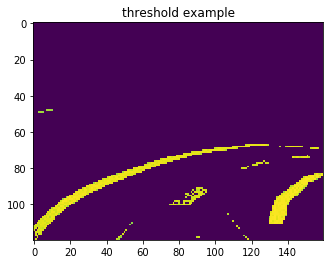

In [4]:
# Label Setup Code:

import os
import natsort
import cv2 

path = 'U_Net_Prototyping/U_Data/U_Train/images/'

done_path = 'U_Net_Prototyping/U_Data/U_Train/masks/'

lst = os.listdir(path)
imlist = []

natsort.natsorted(lst,reverse=False)
i = 1

for file in os.listdir(path):
    imlist.append(file)

#print(imlist)
imlist.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

for file in imlist:
   os.rename(os.path.join(path, file), os.path.join(path, str(i)+'_cam-image_array_'+ '.jpg'))
   i = i+1
imlist = []
for file in os.listdir(path):
    imlist.append(file)

imlist.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#print(imlist)
#print(i)

    
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold_white = [red_threshold, green_threshold, blue_threshold]

i = 1
for file in imlist:
    image = cv2.imread(path + str(i) + '_cam-image_array_.jpg', 1)
    colorMaskWhite = (image[:,:,0] < rgb_threshold_white[0]) | \
                    (image[:,:,1] < rgb_threshold_white[1]) | \
                    (image[:,:,2] < rgb_threshold_white[2])
    localImage = np.copy(image)
    localImage[colorMaskWhite] = [0,0,0]
    (height, width) = localImage.shape[:2]
    point = round(height/3) #create an roi to eliminate unwanted details
    localImage[:point, :width, :] = [0,0,0]
    localImage = cv2.cvtColor(localImage, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(done_path + str(i) +'_mask_.jpg', localImage)
    i = i+1

plt.title('threshold example')
plt.imshow(localImage)
print(i)
print(localImage.shape)

## Training and Validation Data setup

The training and validation data used for this particular U-Net was collected in a lecture hall in preparation for the 2019 
DonkeyCar Presentation, thus this dataset is not representative of all possible locations that the donkeycar will find itself in
meaning that this example will be an overfit model. However, for the purposes of illustrating the use of a U-Net, this will suffice


In [5]:
# Imports - Always run first!
import os
import sys
import random
import warnings
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
%matplotlib inline

Getting and resizing train images and masks ... 


  5%|█████▏                                                                                        | 7/128 [00:00<00:01, 69.35it/s]

getting and resizing test images:


100%|████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 70.17it/s]


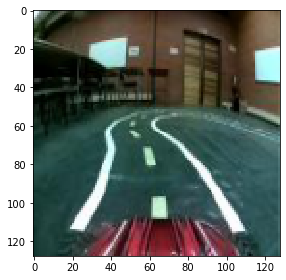

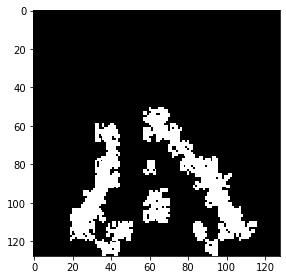

In [6]:
# Data setup:

#Data management:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'U_Net_Prototyping/U_Data/U_Train/'
TEST_PATH = 'U_Net_Prototyping/U_Data/U_Test/'

# Get and order train and test filenames
imgs = []
masks = []
test = []

impath = TRAIN_PATH + 'images/'
maskpath = TRAIN_PATH + 'masks/'

for file in os.listdir(impath):
    imgs.append(file)

for file in os.listdir(maskpath):
    masks.append(file)

for file in os.listdir(TEST_PATH):
    test.append(file)

imgs.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
masks.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

X_train = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) #create training and testing data tensors
Y_train = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) #create training and testing data tensors
 
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

i = 1
#Loop through image files and extract data files into numpy arrays
for n, filename in tqdm(enumerate(imgs), total=len(imgs)):
    path = TRAIN_PATH
    img = imread(path + '/images/' + filename)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask_ = imread(path + '/masks/' + str(i) + '_mask_.jpg')
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis = 2)
    mask = mask_ > 200
    Y_train[n] = mask_
    i = i+1

print('getting and resizing test images:')
#get test data:
for n, filename in tqdm(enumerate(test), total=len(test)):
    path = TEST_PATH
    img = imread(path + filename)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

#Just to check if the images are, like, split correctly
ix = np.random.randint(0,len(test))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Network Setup

This network setup is adapted from a model seen on Kaggle. It mostly uses precisely the same structure and layer composition
since this was already a working model. However, some small changes were made - such as the number of dimensions in the convol-
ution layers


In [11]:
#Training and Validation

#imports:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

#Network Metric - Intersection over Union or Jaccard Index:

def sparse_Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    pred_pixels = K.argmax(y_pred, axis=-1)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(y_true[:,:,0], i)
        pred_labels = K.equal(pred_pixels, i)
        inter = tf.dtypes.cast(true_labels & pred_labels, tf.int32)
        union = tf.dtypes.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.dtypes.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    #legal_labels = ~tf.debugging.is_nan(iou)
    #legal_labels = tf.debugging.assert_none_equal(iou, 'nan')
    #iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)
#Network Construction:
                  
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
________________________________________________________________________________

In [12]:
#Fit model to data:

earlystopper = EarlyStopping(patience=5, verbose=1)  #Patience can be varied to change early stopping behaviour
checkpointer = ModelCheckpoint('UNetSeg.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 444 samples, validate on 50 samples
Epoch 1/50
432/444 [============================>.] - ETA: 3s - loss: 0.5215 - acc: 0.7916
Epoch 00001: val_loss improved from inf to 0.40184, saving model to UNetSeg.h5
444/444 [==============================] - 130s 293ms/sample - loss: 0.5193 - acc: 0.7933 - val_loss: 0.4018 - val_acc: 0.8664
Epoch 2/50
432/444 [============================>.] - ETA: 3s - loss: 0.4062 - acc: 0.8631
Epoch 00002: val_loss improved from 0.40184 to 0.34923, saving model to UNetSeg.h5
444/444 [==============================] - 131s 295ms/sample - loss: 0.4060 - acc: 0.8629 - val_loss: 0.3492 - val_acc: 0.8644
Epoch 3/50
432/444 [============================>.] - ETA: 2s - loss: 0.3659 - acc: 0.8662
Epoch 00003: val_loss improved from 0.34923 to 0.32657, saving model to UNetSeg.h5
444/444 [==============================] - 98s 221ms/sample - loss: 0.3653 - acc: 0.8664 - val_loss: 0.3266 - val_acc: 0.8706
Epoch 4/50
432/444 [============================>.] - ETA

Epoch 00028: early stopping


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
128/128 [==============================] - 20s 160ms/sample


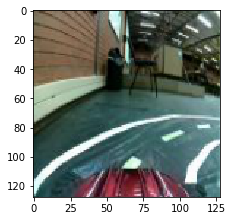

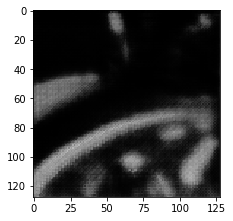

In [13]:
# predict from model with random images

ix = np.random.randint(0, len(test))

model = load_model('UNetSeg.h5')


pred_im = model.predict(X_test, verbose=1)

plt.subplot(121)
imshow(X_test[ix])
plt.show()
plt.subplot(122)
imshow(np.squeeze(pred_im[ix]))
plt.show()


In [14]:
print(pred_im[ix].shape)
print(X_test[ix].shape)


(128, 128, 1)
(128, 128, 3)


# This Model IS NOT  LEARNING ^

Even though this an (apparently) working model from a Kaggle competition, this network is not learning at all. Blindly trying to adjust the learning rate, number of hidden layers and units, and other hyper parameters will not be effective at the moment. 

For that reason, the UNet problem is sitting on the backburner at present, to be fully investigated from scratch at another time. Hopefully a time when there is more knowledge

# Main Pilot

The donkeycar main pilot consists of a deep CNN that can either be a categorical model, a linear model, or even a 3D CNN. Of
the several types of models and pilots implemented in the Donkeycar Library, the model that will be analysed and then re-implemented is the categorical model - which appears to be the default. 

## Part 1: Sorting Out Data

 The data that is going to be fed into the model is the thresholded images generated from a numpy mask. This model will be tested on data collected on a different track - which will also consist of thresholded images. In a later iteration, performance on different datasets without thresholding will be compared.

15795
15795
15795
15795
(15795, 120, 160)


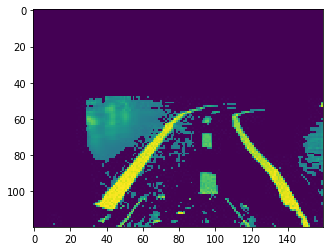

[0 0 1]


In [5]:
import os
import natsort
import numpy as np
import cv2
import json

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
path = 'thresh_im_2/' #When using thresholded images

record_path = 'halldatarecords2/'#when using thresholded images

im_list = []

rec_list = []

#for file in os.listdir(path):  #when using unthresholded images
#    if 'cam' in file:
#        im_list.append(file)
#    elif 'record' in file:
#        rec_list.append(file)


#When using thresholded images:
for file in os.listdir(path):
    im_list.append(file)
    
for file in os.listdir(record_path):
    if 'record' in file:
        rec_list.append(file)

print(len(im_list))
print(len(rec_list))

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
#x_images = np.zeros((len(rec_list), 120, 160, 3), dtype = np.uint8)
x_images = np.zeros((len(rec_list), 120, 160), dtype = np.float32) #When using Thresholded Data
for i in range(len(im_list)):
    filename = im_list[i]
    #x_images[i,:,:,:] = cv2.imread(path+filename)
    x_images[i,:,:] = cv2.imread(path+filename,0)
#loop over labels and create a list of left/right/straight based on a degree threshold (one-hot encoding?)
json_data = {}
y_labels = np.zeros((len(rec_list),3), dtype=np.uint8) #setup label array for one-hot encoded left, right and straight
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(record_path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        orient = float(orient)
        if orient > 0.05:
            y_labels[i] = [0,0,1] #right
            
        elif orient < -0.05:
            y_labels[i] = [1,0,0] #left
            
        else:
            y_labels[i] = [0,1,0] #straight
            
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
plt.imshow(x_images[1000])
plt.show()
print(y_labels[1000])

In [6]:
#training and validation split:

memv = 0
memt = 0
#x_val = np.zeros((round(len(x_images)*0.3)+1,120,160,3), dtype=np.uint8)
#x_train = np.zeros((round(len(x_images)*0.7)+1,120,160,3), dtype=np.uint8)
x_val = np.zeros((round(len(x_images)*0.3)+1,120,160), dtype=np.float32) #when using thresholded data
x_train = np.zeros((round(len(x_images)*0.7)+1,120,160), dtype=np.float32) #when using thresholded data
y_val = np.zeros((round(len(x_images)*0.3)+1,3), dtype=np.float32)
y_train = np.zeros((round(len(x_images)*0.7)+1,3), dtype=np.float32)
n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            x_val[l] = x_images[j+o,:,:]
            y_val[l] = y_labels[j+o,:]
            o +=1
        for m in range(0+n*700, n*700+700):
            x_train[m] = x_images[k+p,:,:]
            y_train[m] = y_labels[k+p,:]
            p+=1
        n+=1

x_train = np.expand_dims(x_train, axis=3) #When using thresholded data
x_val = np.expand_dims(x_val, axis = 3) #when using thresholded data
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)
x_train = x_train/255  #make the initial weights of the images small - between 0 and 1
x_val = x_val/255
#obtaining test data

#relabeling test data

(15795, 3)
700
1700
2700
3700
4700
5700
6700
7700
8700
9700
10700
11700
12700
13700
14700
(11057, 120, 160, 1)
(4739, 120, 160, 1)
(11057, 3)
(4739, 3)


## Part 2: Models

The output of this model will be three possible outcomes - left, right or straight. This means that the final layer will be a dense layer of 3 neurons with softmax activation. The loss function that this network will be trained on is categorical crossentropy. This network will be a shallow CNN, as most of the features (for now) are neutralised using thresholding of images. 

### Categorical Model 1

In [1]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda
from tensorflow.python.keras.optimizers import SGD, Adam

C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\l

#### Model Setup:

In [4]:
#Model Structure Setup: no dropout, no regularization yet

model = Sequential()
#model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160, 3)))
model.add(Convolution2D(32, (5,5), strides=(2,2), activation='relu', kernel_initializer='he_uniform', input_shape=(120, 160, 1)))#Thresholded Data
model.add(Convolution2D(64,(5,5), strides=(2,2), activation ='relu', kernel_initializer='he_uniform'))
#model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu', kernel_initializer='he_normal'))
model.add(Convolution2D(128, (3,3), strides=(2,2), activation='relu', kernel_initializer='he_uniform'))
#model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu', kernel_initializer='he_normal'))
#model.add(Convolution2D(128, (3,3), strides=(2,2), activation='relu', kernel_initializer='he_normal'))
model.add(Flatten())
#model.add(Dense(1000, activation = 'relu'))
model.add(Dense(512, activation='relu'))
#model.add(Dense(250, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 58, 78, 32)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 37, 64)        51264     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 18, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 29952)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               15335936  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 15,463,427
Trainable params: 15,463,427
Non-trainable params: 0
__________________________________________

#### Training and Validation:

In [6]:
# Compile model:
learning_rate = 0.00001
epochs =20
decay = learning_rate/epochs
momentum = 0
adam = Adam(lr=learning_rate, decay=decay)
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
#Callbacks:



In [7]:
model.fit(x_train, y_train, epochs=epochs, batch_size=200, validation_data=(x_val, y_val), shuffle=True, verbose=1)

NameError: name 'x_train' is not defined

In [12]:
out = model.predict(x_val, batch_size=200)

right


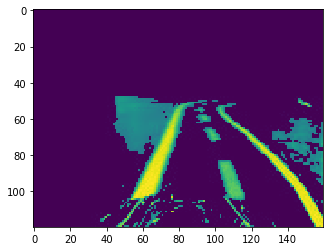

[0.0123803 0.1382728 0.8493468]


In [17]:
num = 2400

if out[num,0] > 0.5:
    print('left')
elif out[num, 1] > 0.5:
    print('straight')
elif out[num, 2] > 0.5:
    print('right')
    
plt.imshow(x_images[num])
plt.show()
print(out[num])

In [ ]:
#Network Design - Own Design 1 

#Own Design 1 Dashboard with intermediate features - single validation example

#Own Design #n etc.
#Final Design Choices

#Compiled Full Pilot System - I.P.O and dashboard with selectable input images 

#### Test dataset and testing:

### Linear Regression Model 1

A linear regression model is also attempted - instead of categorically slotting outputs into 'left', 'right' and 'straight', the floating point values representing the degree of rotation are instead used as labels. The error that will be calculated will be the mean squared error, and the optimizer for this model will be rmsprop. An identical regression model will also be built with RMSProp as the optimizer.

#### Data Preparation

15795
15795
15795
15795
(15795, 120, 160)


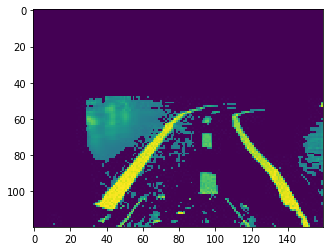

0.2


In [34]:
import os
import natsort
import numpy as np
import cv2
import json

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
path = 'thresh_im_2/' #When using thresholded images

record_path = 'halldatarecords2/'#when using thresholded images

im_list = []

rec_list = []

#for file in os.listdir(path):  #when using unthresholded images
#    if 'cam' in file:
#        im_list.append(file)
#    elif 'record' in file:
#        rec_list.append(file)


#When using thresholded images:
for file in os.listdir(path):
    im_list.append(file)
    
for file in os.listdir(record_path):
    if 'record' in file:
        rec_list.append(file)

print(len(im_list))
print(len(rec_list))

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
#x_images = np.zeros((len(rec_list), 120, 160, 3), dtype = np.uint8)
x_images = np.zeros((len(rec_list), 120, 160), dtype = np.float32) #When using Thresholded Data
for i in range(len(im_list)):
    filename = im_list[i]
    #x_images[i,:,:,:] = cv2.imread(path+filename)
    x_images[i,:,:] = cv2.imread(path+filename,0)
    
#loop over labels and create a list of left/right/straight based on a degree threshold (one-hot encoding?)
json_data = {}
y_labels = np.zeros((len(rec_list)), dtype=np.float32) #setup label array for one-hot encoded left, right and straight
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(record_path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_labels[i] = orient    
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
plt.imshow(x_images[1000])
plt.show()
print(y_labels[1000])

In [35]:
#training and validation split:

memv = 0
memt = 0
#x_val = np.zeros((round(len(x_images)*0.3)+1,120,160,3), dtype=np.uint8)
#x_train = np.zeros((round(len(x_images)*0.7)+1,120,160,3), dtype=np.uint8)
x_val = np.zeros((round(len(x_images)*0.3)+1,120,160), dtype=np.float32) #when using thresholded data
x_train = np.zeros((round(len(x_images)*0.7)+1,120,160), dtype=np.float32) #when using thresholded data
y_val = np.zeros((round(len(x_images)*0.3)+1,1), dtype=np.float32)
y_train = np.zeros((round(len(x_images)*0.7)+1,1), dtype=np.float32)
n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            x_val[l] = x_images[j+o]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            x_train[m] = x_images[k+p]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1

x_train = np.expand_dims(x_train, axis=3) #When using thresholded data
x_val = np.expand_dims(x_val, axis = 3) #when using thresholded data
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)
x_train = x_train/255  #make the initial weights of the images small - between 0 and 1
x_val = x_val/255
#obtaining test data

#relabeling test data

(15795,)
700
1700
2700
3700
4700
5700
6700
7700
8700
9700
10700
11700
12700
13700
14700
(11057, 120, 160, 1)
(4739, 120, 160, 1)
(11057, 1)
(4739, 1)


#### Model Setup

In [17]:
## Imports:

import os
import numpy as np

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
## Model Structure:

model = Sequential()
#model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160, 3)))
model.add(Convolution2D(32, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160,1))) #For Thresholded Data
#model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
#model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(Convolution2D(128, (3,3), strides=(2,2), activation='relu'))
#model.add(Convolution2D(128, (3,3), strides=(1,1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 58, 78, 32)        832       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 38, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 18, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 29952)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               15335936  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 15,429,633
Trainable params: 15,429,633
Non-trainable params: 0
__________________________________________

In [19]:
## Model Compilation:
earlystopper = EarlyStopping(patience=5, verbose=1)  #Patience can be varied to change early stopping behaviour
checkpointer = ModelCheckpoint('Regression.h5', verbose=1, save_best_only=True)
model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'], callbacks=[earlystopper, checkpointer])

#### Model Training and Validation

In [39]:

model.fit(x_train, y_train, epochs=20, batch_size=200, validation_data=(x_val, y_val), shuffle=True, verbose=1)

Train on 11057 samples, validate on 4739 samples
Epoch 1/20
11057/11057 [==============================] - 59s 5ms/sample - loss: 0.1306 - acc: 0.1656 - val_loss: 0.0493 - val_acc: 0.2211
Epoch 2/20
11057/11057 [==============================] - 55s 5ms/sample - loss: 0.0462 - acc: 0.2398 - val_loss: 0.0385 - val_acc: 0.2222
Epoch 3/20
11057/11057 [==============================] - 56s 5ms/sample - loss: 0.0381 - acc: 0.2411 - val_loss: 0.0419 - val_acc: 0.2222
Epoch 4/20
11057/11057 [==============================] - 68s 6ms/sample - loss: 0.0319 - acc: 0.2427 - val_loss: 0.0440 - val_acc: 0.2216
Epoch 5/20
11057/11057 [==============================] - 59s 5ms/sample - loss: 0.0250 - acc: 0.2427 - val_loss: 0.0475 - val_acc: 0.2201
Epoch 6/20
11057/11057 [==============================] - 58s 5ms/sample - loss: 0.0226 - acc: 0.2433 - val_loss: 0.0487 - val_acc: 0.2201
Epoch 7/20
11057/11057 [==============================] - 54s 5ms/sample - loss: 0.0175 - acc: 0.2434 - val_loss: 0.0

[0.1563041]
Truth:
[0.4857143]


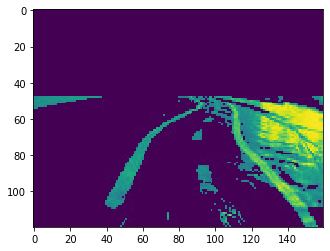

In [41]:
# Run Prediction:

outs = model.predict(x_val, batch_size = 200)
    
print(outs[2500])
print('Truth:')
print(y_val[2500])
plt.imshow(np.squeeze(x_val[2500]))
plt.show()

#### Test Data and Testing